# Semester Project Midterm presentation

In [82]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd

from matplotlib.pyplot import figure
from sklearn.metrics import plot_confusion_matrix

In [83]:
import read_audio
import params
import training
import feature_engineering

In [84]:
example_drums = {"kick": "/Users/rayandaod/Documents/Prod/My_samples/Medasin Overdose 3/MM_2099_drums/MM_2099_kicks/MM_2099_kick_04.wav",
                "snare": "/Users/rayandaod/Documents/Prod/My_samples/Medasin Overdose 3/MM_2099_drums/MM_2099_snares/MM_2099_snare_05.wav",
                "hat": "/Users/rayandaod/Documents/Prod/My_samples/Medasin Overdose 3/MM_2099_drums/MM_2099_hihats/MM_2099_hihat_02.wav",
                "tom": "/Users/rayandaod/Documents/Prod/My_samples/KSHMR Vol. 2/Drums/Toms/KSHMR Basic Tom 03 - G#.wav"}

## 1. Drum types

### 1.1 Kick example

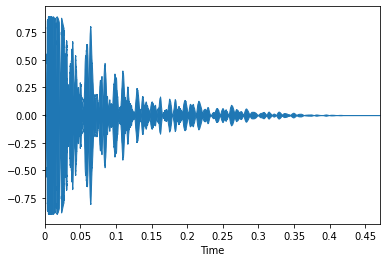

In [125]:
raw_audio = read_audio.load_raw_audio(example_drums['kick'])
librosa.display.waveplot(raw_audio)
ipd.Audio(example_drums['kick'])

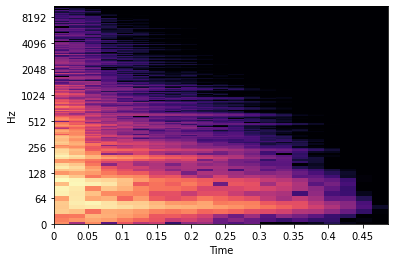

In [86]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(raw_audio)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time')

### 1.2 Snare example

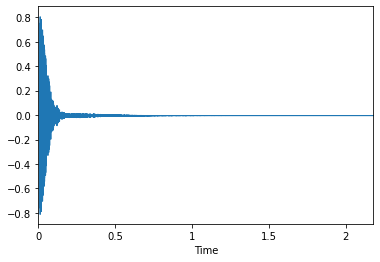

In [126]:
raw_audio = read_audio.load_raw_audio(example_drums['snare'])
librosa.display.waveplot(raw_audio)
ipd.Audio(example_drums['snare'])

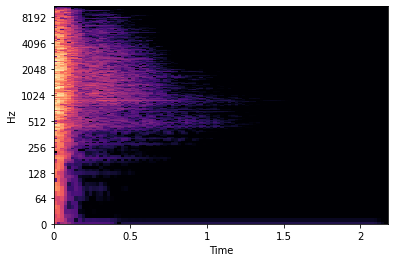

In [88]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(raw_audio)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time')

### 1.3 Hat example

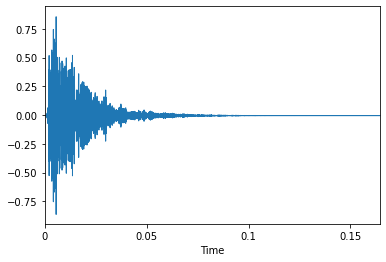

In [127]:
raw_audio = read_audio.load_raw_audio(example_drums['hat'])
librosa.display.waveplot(raw_audio)
ipd.Audio(example_drums['hat'])

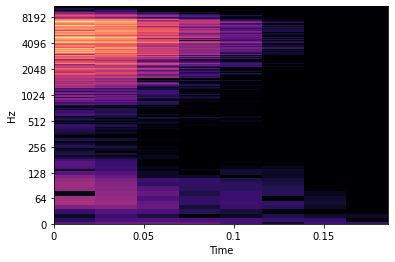

In [90]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(raw_audio)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time')

### 1.4 Tom example

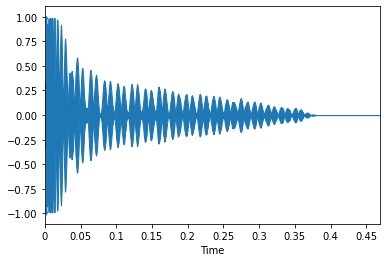

In [128]:
raw_audio = read_audio.load_raw_audio(example_drums['tom'])
librosa.display.waveplot(raw_audio)
ipd.Audio(example_drums['tom'])

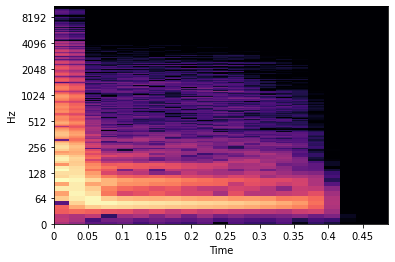

In [92]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(raw_audio)), ref=np.max)
librosa.display.specshow(D, y_axis='log', x_axis='time')

## 2. Preprocessing

Load every .wav file of my sample library

Check if each sample belongs to one of our classes, if not: discarded

### 2.1 Blacklisted keywords

In [93]:
a_file = open(params.BLACKLIST_PATH)
lines = a_file.readlines()
for line in lines:
    print(line)

roll,stomp,enhancer


### 2.2 Ignored keywords

In [94]:
a_file = open(params.IGNORE_PATH)
lines = a_file.readlines()
for line in lines:
    print(line)

that


### 2.3 Onset detection

Onset detection allows us to retrieve the first drum hit in a drum loop and consider it as a drum sample for our dataset, and to trim the samples if some have a silence period at the beginning.

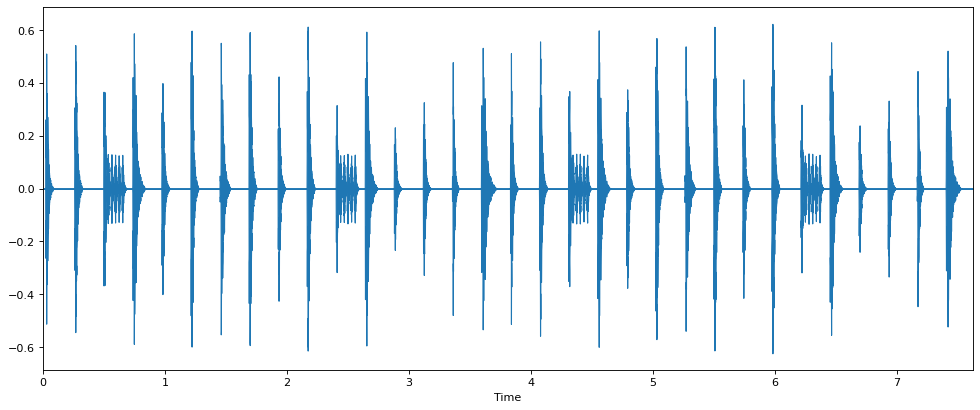

In [95]:
raw_audio = read_audio.load_raw_audio("/Users/rayandaod/Documents/Prod/My_samples/Decap - Drums that Knock Vol 6/Decap - Drums that Knock Vol 6/Hihat + Percussion Loops/Rain or Sun Hihat Loop (126BPM).wav")
figure(figsize=(15, 6), dpi=80)
librosa.display.waveplot(raw_audio)
ipd.Audio("/Users/rayandaod/Documents/Prod/My_samples/Decap - Drums that Knock Vol 6/Decap - Drums that Knock Vol 6/Hihat + Percussion Loops/Rain or Sun Hihat Loop (126BPM).wav")

Add an empty second so that the beginning onset is recognized

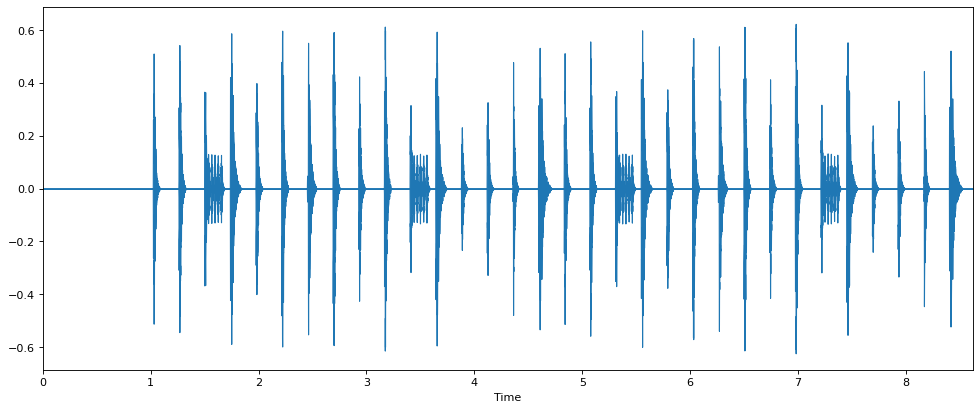

In [96]:
start = 0.0
end = None
silence_to_add = 1.0
raw_audio = np.append(np.zeros(int(silence_to_add * params.DEFAULT_SR)), raw_audio)
figure(figsize=(15, 6), dpi=80)
librosa.display.waveplot(raw_audio)

In [97]:
hop_length = int(params.DEFAULT_SR * params.SR_FRACTION_FOR_TRIM)
onsets = librosa.onset.onset_detect(y=raw_audio, hop_length=hop_length, units='time')
print(onsets)

[1.02267574 1.26213152 1.5015873  1.74104308 1.9755102  2.21496599
 2.45442177 2.68888889 2.92834467 3.16780045 3.40725624 3.64172336
 3.88117914 4.12063492 4.3600907  4.59455782 4.83401361 5.07346939
 5.30793651 5.54739229 5.78684807 6.02131519 6.26575964 6.50022676
 6.73968254 6.97414966 7.21360544 7.45306122 7.69251701 7.92698413
 8.17142857 8.40589569]


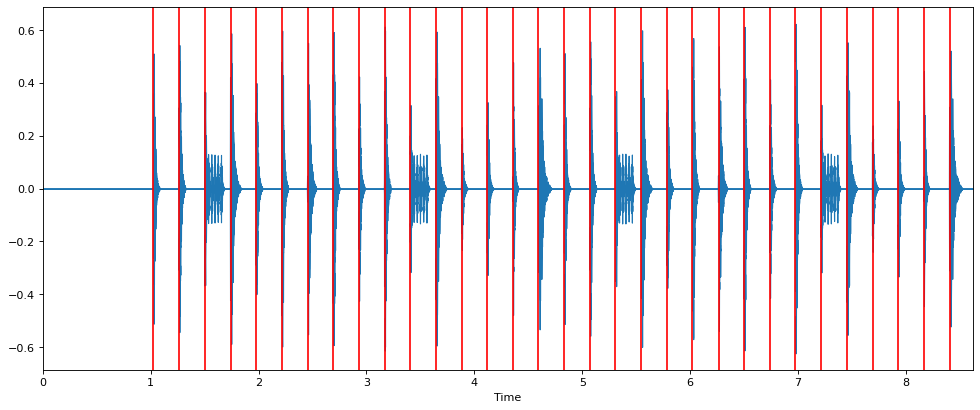

In [98]:
figure(figsize=(15, 6), dpi=80)
librosa.display.waveplot(raw_audio)
for o in onsets:
    plt.axvline(x=o, color='red')

In [99]:
if len(onsets) == 0:
    print("Found no onset...")
elif len(onsets) > 1:
    # If there are multiple onsets, cut it off just before the second one
    end = onsets[1] - (silence_to_add + 0.01)

start = max(onsets[0] - (silence_to_add + 0.01), 0.0)

print("Start: {} seconds\nEnd: {} seconds".format(start, end))

Start: 0.01267573696145119 seconds
End: 0.2521315192743765 seconds


### 2.4 New duration

Thanks to the onset detection shown above, we have a new duration for some of our loaded samples, we can see it with the duration histograms below:

In [100]:
drums_df = pd.read_pickle(params.PICKLE_DATAFRAME_NOT_CAPED_PATH)

In [101]:
dataframes = []
for drum_type in params.DRUM_TYPES:
    new_df = drums_df[drums_df["class"] == drum_type]
    new_df.name = "{drum_type}s"
    dataframes.append(new_df)

In [102]:
def draw_hist(df, drum_type, column):
    ax_list = df.hist(column=column, bins=200, figsize=(15,5), legend=True)
    ax_list[0][0].set_xlim((0, 50))
    ax_list[0][0].set_yscale("log")
    plt.title("{}s".format(drum_type))
    plt.xlabel('Time in seconds')
    plt.ylabel('Number of samples')

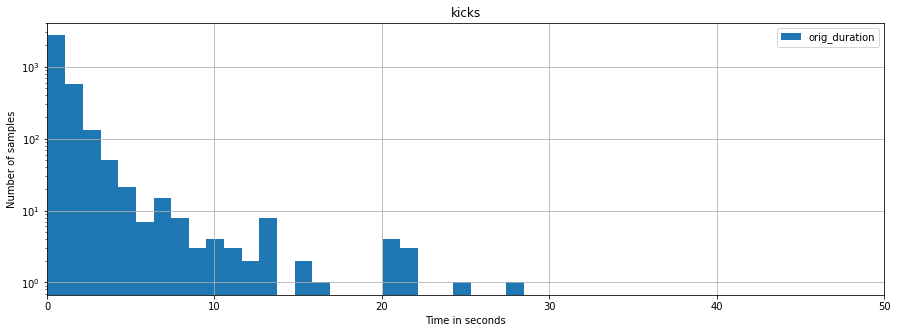

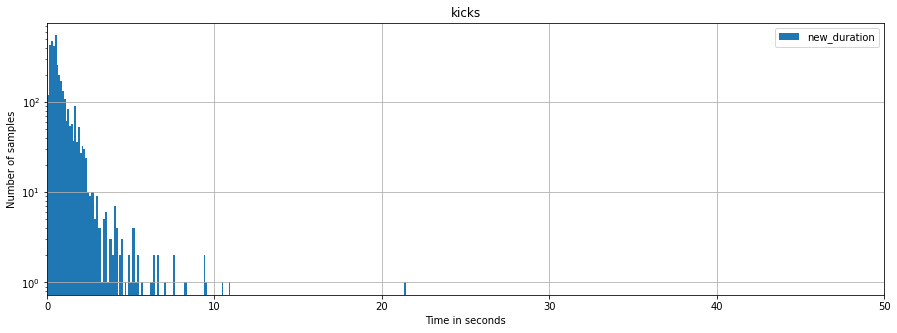

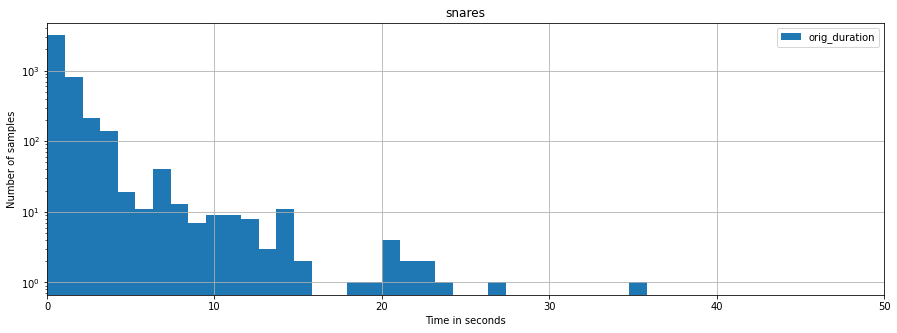

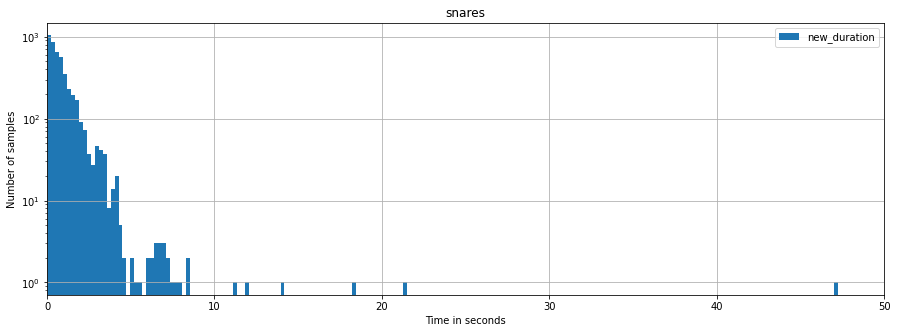

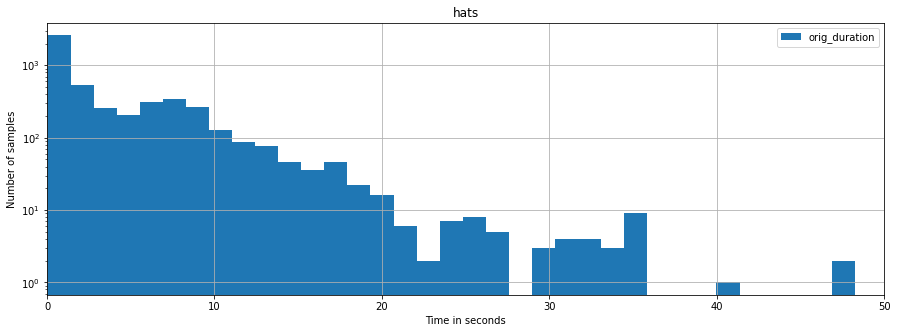

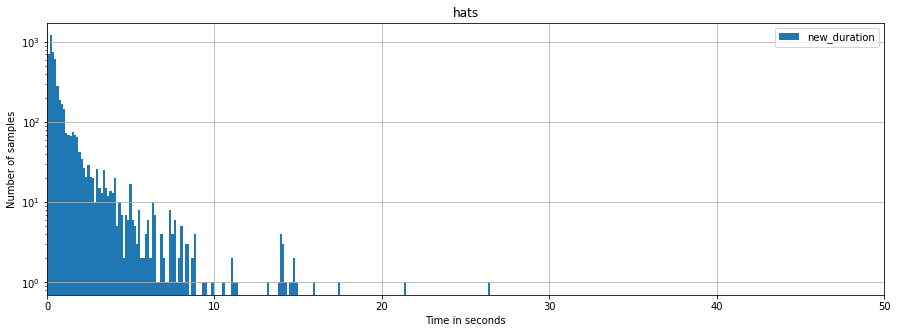

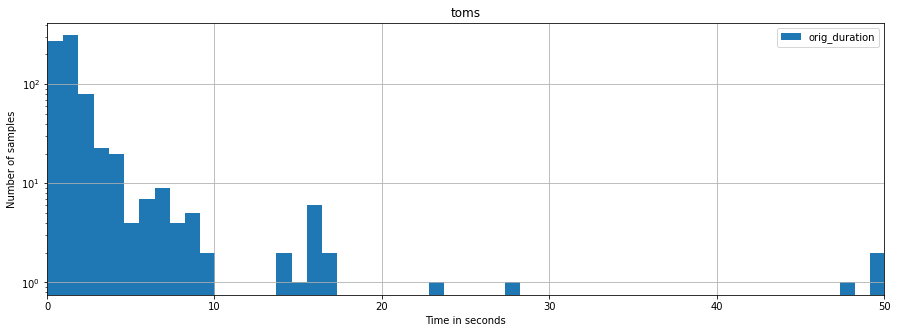

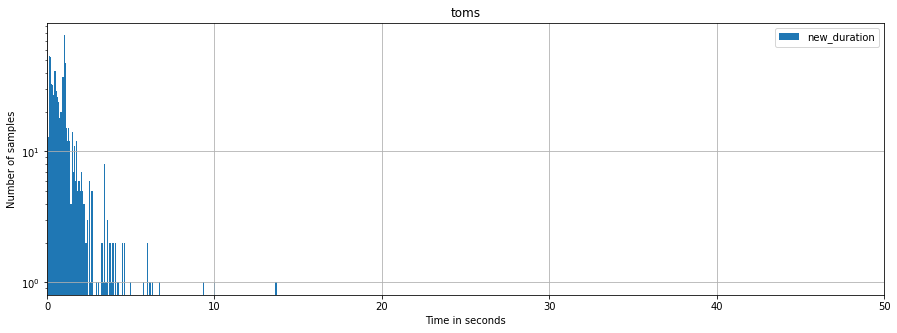

In [103]:
for i in range(len(dataframes)):
    draw_hist(dataframes[i], params.DRUM_TYPES[i], column="orig_duration")
    draw_hist(dataframes[i], params.DRUM_TYPES[i], column="new_duration")

### 2.5 Filter quiet outliers

In [104]:
#TODO

### 2.6 First Dataset

In [105]:
drums_df = pd.read_pickle(params.PICKLE_DATASET_PATH)

In [106]:
drums_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13676 entries, 0 to 15182
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   audio_path     13676 non-null  object 
 1   file_stem      13676 non-null  object 
 2   class          13676 non-null  object 
 3   start_time     13676 non-null  float64
 4   end_time       2613 non-null   float64
 5   orig_duration  13676 non-null  float64
 6   new_duration   13676 non-null  float64
dtypes: float64(4), object(3)
memory usage: 854.8+ KB


In [107]:
drums_df.head()

audio_path         file_stem class  \
0  /Users/rayandaod/Documents/Prod/My_samples/AP1...   ap11 open hat 8   hat   
1  /Users/rayandaod/Documents/Prod/My_samples/AP1...   ap11 open hat 9   hat   
2  /Users/rayandaod/Documents/Prod/My_samples/AP1...  ap11 open hat 11   hat   
3  /Users/rayandaod/Documents/Prod/My_samples/AP1...  ap11 open hat 10   hat   
4  /Users/rayandaod/Documents/Prod/My_samples/AP1...  ap11 open hat 12   hat   

   start_time  end_time  orig_duration  new_duration  
0    0.002698       NaN       0.560000      0.557302  
1    0.000000       NaN       0.395057      0.395057  
2    0.000000       NaN       0.400000      0.400000  
3    0.000000   0.55644       0.897324      0.556440  
4    0.000000       NaN       1.935465      1.935465

In [108]:
drums_df['class'].value_counts()

hat      4916
snare    4460
kick     3550
tom       750
Name: class, dtype: int64

<AxesSubplot:>

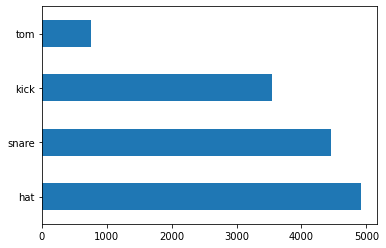

In [109]:
drums_df['class'].value_counts().plot(kind='barh')

## 3. Feature Extraction

### 3.1 Example

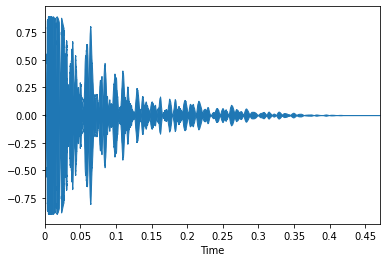

In [110]:
raw_audio = read_audio.load_raw_audio(example_drums['kick'])
librosa.display.waveplot(raw_audio)
ipd.Audio(example_drums['kick'])

In [111]:
features = feature_engineering.extract_single(raw_audio)
feature_keys = np.array(list(features.keys()))
features

{'log_attack_time': -1.9351686284920078,
 'temporal_centroid': 0.09776299582390974,
 'lat_tc_ratio': -19.794489849488908,
 'duration': 0.3482993197278912,
 'release': 0.3250793650793651,
 'crest_factor': 3.050610160690308,
 'log_rms_avg': -1.0451015662615952,
 'log_rms_std': 0.41832001209610864,
 'log_rms_min': -1.6284624164676704,
 'log_rms_max': -0.3634687516541482,
 'log_rms_d_avg': -0.10219922407513139,
 'log_rms_d_max': -0.02097723388078987,
 'log_rms_d_min': -0.16519542016926092,
 'log_rms_d_std': 0.041351767950571244,
 'log_rms_d_zcr': 0.0,
 'zcr_avg': 0.007098858173076923,
 'zcr_min': 0.00439453125,
 'zcr_max': 0.013671875,
 'zcr_std': 0.0027728408691844574,
 'zcr_loudest': 0.0087890625,
 'log_spec_cent_avg': 2.5551010749492633,
 'log_spec_cent_min': 2.3066384217902844,
 'log_spec_cent_max': 2.8133451901695703,
 'log_spec_cent_std': 0.15005480319627498,
 'log_spec_cent_loudest': 2.8133451901695703,
 'log_spec_cent_d_avg': -0.04413417091615142,
 'log_spec_cent_d_max': 0.00489380

Do that for every row...

### 3.2 Almost final Dataset

In [112]:
drums_df = pd.read_pickle(params.PICKLE_DATASET_WITH_FEATURES_PATH)

In [113]:
drums_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13676 entries, 0 to 13675
Columns: 120 entries, log_attack_time to drum_type
dtypes: float64(119), object(1)
memory usage: 12.5+ MB


In [114]:
drums_df.head()

log_attack_time  temporal_centroid  lat_tc_ratio  duration   release  \
0        -1.333109           0.209090     -6.375773  0.580499  0.510839   
1        -1.634139           0.237434     -6.882492  0.301859  0.255420   
2        -1.935169           0.255884     -7.562672  0.348299  0.325079   
3        -1.333109           0.227221     -5.867003  0.557279  0.487619   
4        -0.855987           0.198759     -4.306670  0.835918  0.673379   

   crest_factor  log_rms_avg  log_rms_std  log_rms_min  log_rms_max  ...  \
0      1.708671    -1.095199     0.193141    -1.458124    -0.822012  ...   
1      1.376171    -1.358095     0.151583    -1.648375    -1.195269  ...   
2      1.576832    -1.416383     0.133730    -1.623729    -1.198029  ...   
3      1.247639    -1.524022     0.082102    -1.684838    -1.420440  ...   
4      1.305043    -1.438303     0.110468    -1.646460    -1.309281  ...   

   mfcc_10_std  mfcc_10_loudest  mfcc_10_d_avg  mfcc_11_avg  mfcc_11_min  \
0     1.734443        -3.704846       0.219318     0.767452    -7.195876   
1     1.490180        -1.155266       0.288395    -1.104318    -3.171138   
2     1.261661         4.536753      -0.060295    -0.721951    -3.711762   
3     0.378229         0.014205       0.070187    -0.060920    -0.692500   
4     0.504165        -0.083374       0.002024    -1.916606    -2.898261   

   mfcc_11_max  mfcc_11_std  mfcc_11_loudest  mfcc_11_d_avg  drum_type  
0     5.343866     2.722848         0.064678       0.056537        hat  
1     1.843427     1.566857         0.803275      -0.290617        hat  
2     1.638715     1.536413        -2.038005      -0.128192        hat  
3     0.523886     0.344132         0.255562       0.064283        hat  
4    -0.843075     0.751850        -2.192798       0.058489        hat  

[5 rows x 120 columns]

## 4. Training

- Split the data into a training set and a test set, by randomly choosing X samples per class
- Replace the NaNs with sklearn's IterativeImputer
- Standardize the columns
- Training time!

In [115]:
model, test_X, test_Y, labels = training.train(drums_df, "random_forest")

INFO:training:Model output can be decoded with the following order of drum types: ['hat', 'tom', 'snare', 'kick']
INFO:training:None
INFO:training:2250 training sounds, 750 validation sounds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 13651
Columns: 121 entries, log_attack_time to drum_type_labels
dtypes: float64(119), int64(1), object(1)
memory usage: 2.8+ MB


INFO:training:random_forest:
INFO:training:              precision    recall  f1-score   support

         hat       0.89      0.86      0.87       189
         tom       0.87      0.85      0.86       193
       snare       0.87      0.89      0.88       201
        kick       0.88      0.90      0.89       167

    accuracy                           0.87       750
   macro avg       0.87      0.88      0.88       750
weighted avg       0.87      0.87      0.87       750



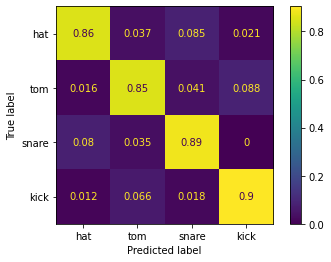

<Figure size 1200x1200 with 0 Axes>

In [116]:
plot_confusion_matrix(model, test_X, test_Y, display_labels=labels, normalize='true')
figure(figsize=(15, 15), dpi=80)
plt.show()

Feature ranking:
1. feature 16 (0.059722)
2. feature 43 (0.058444)
3. feature 21 (0.042934)
4. feature 15 (0.035635)
5. feature 17 (0.030519)
6. feature 20 (0.028630)
7. feature 46 (0.028601)
8. feature 36 (0.026867)
9. feature 49 (0.025394)
10. feature 51 (0.025007)
11. feature 41 (0.022518)
12. feature 52 (0.021020)
13. feature 47 (0.019955)
14. feature 24 (0.018824)
15. feature 42 (0.018309)
16. feature 35 (0.017999)
17. feature 113 (0.017657)
18. feature 19 (0.017138)
19. feature 101 (0.015454)
20. feature 107 (0.014068)
21. feature 89 (0.013407)
22. feature 18 (0.013036)
23. feature 23 (0.012434)
24. feature 27 (0.012186)
25. feature 95 (0.011632)
26. feature 50 (0.011543)
27. feature 115 (0.009336)
28. feature 77 (0.008850)
29. feature 83 (0.008120)
30. feature 90 (0.007688)
31. feature 55 (0.007078)
32. feature 103 (0.006958)
33. feature 12 (0.006912)
34. feature 9 (0.006743)
35. feature 6 (0.006581)
36. feature 22 (0.006580)
37. feature 33 (0.006560)
38. feature 10 (0.006494)
3

<Figure size 432x288 with 0 Axes>

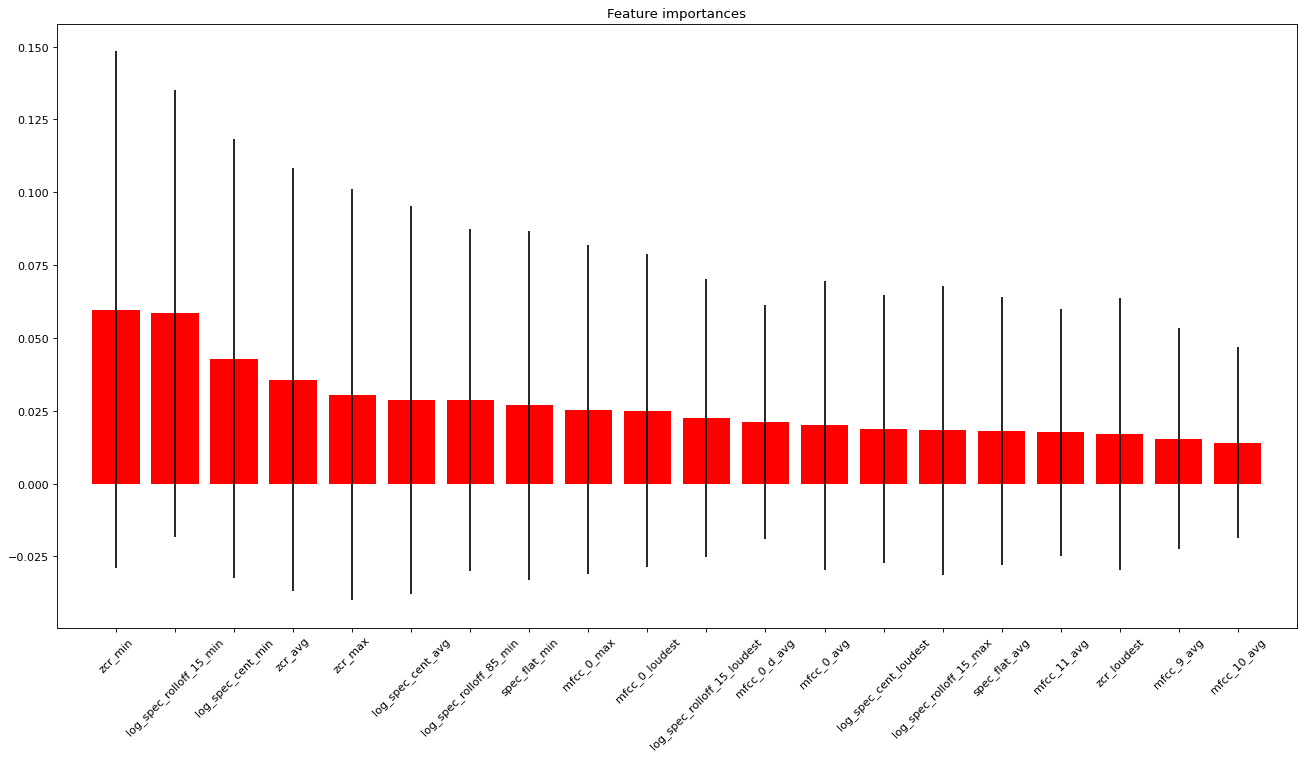

In [117]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(test_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
figure(figsize=(20, 10), dpi=80)
plt.title("Feature importances")
plt.bar(range(test_X.shape[1])[:20], importances[indices][:20],
        color="r", yerr=std[indices][:20], align="center")
plt.xticks(range(20), feature_keys[indices[:20]])
plt.xticks(rotation=45)
plt.xlim([-1, 20])
plt.show()

In [118]:
model, test_X, test_Y, labels = training.train(drums_df, "knn")

INFO:training:Model output can be decoded with the following order of drum types: ['hat', 'tom', 'snare', 'kick']
INFO:training:None
INFO:training:2250 training sounds, 750 validation sounds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 13651
Columns: 121 entries, log_attack_time to drum_type_labels
dtypes: float64(119), int64(1), object(1)
memory usage: 2.8+ MB


INFO:training:knn:
INFO:training:              precision    recall  f1-score   support

         hat       0.84      0.87      0.85       189
         tom       0.84      0.82      0.83       193
       snare       0.90      0.85      0.87       201
        kick       0.85      0.89      0.87       167

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750



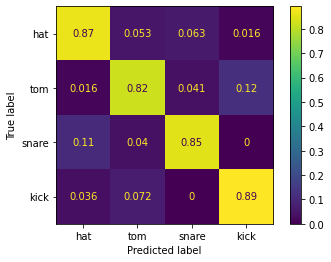

<Figure size 1200x1200 with 0 Axes>

In [119]:
plot_confusion_matrix(model, test_X, test_Y, display_labels=labels, normalize='true')
figure(figsize=(15, 15), dpi=80)
plt.show()

In [120]:
model, test_X, test_Y, labels = training.train(drums_df, "svc")

INFO:training:Model output can be decoded with the following order of drum types: ['hat', 'tom', 'snare', 'kick']
INFO:training:None
INFO:training:2250 training sounds, 750 validation sounds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 13651
Columns: 121 entries, log_attack_time to drum_type_labels
dtypes: float64(119), int64(1), object(1)
memory usage: 2.8+ MB


INFO:training:svc:
INFO:training:              precision    recall  f1-score   support

         hat       0.90      0.84      0.87       189
         tom       0.86      0.83      0.84       193
       snare       0.87      0.91      0.89       201
        kick       0.85      0.90      0.87       167

    accuracy                           0.87       750
   macro avg       0.87      0.87      0.87       750
weighted avg       0.87      0.87      0.87       750



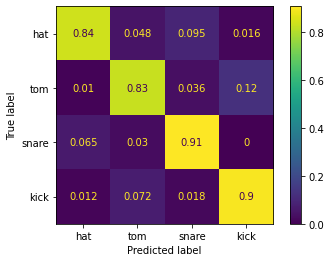

<Figure size 1200x1200 with 0 Axes>

In [121]:
plot_confusion_matrix(model, test_X, test_Y, display_labels=labels, normalize='true')
figure(figsize=(15, 15), dpi=80)
plt.show()